# Advanced RNN Models for Toxic Comment Classification

This notebook implements and compares various RNN architectures (LSTM, GRU, Bidirectional RNNs) using different embedding techniques for the toxic comment classification task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import os
import nltk
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F


# Deep learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# For pre-trained embeddings
import gensim
from gensim.models import KeyedVectors

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load and Prepare Data

In [3]:
# Load preprocessed data
train_data = pd.read_csv('../Dataset/train_preprocessed.csv')

# Check the data
print(f"Training data shape: {train_data.shape}")
train_data.head()

Training data shape: (159571, 12)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_text,original_length,processed_length,length_reduction
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made my username hardcore me...,264,202,23.484848
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww ! he match background colour im seemingly...,112,86,23.214286
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man , im really not trying edit war . guy ...",233,165,29.184549
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,i cant make real suggestion improvement i wond...,622,406,34.726688
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you , sir , my hero . chance you remember page...",67,54,19.402985


In [4]:
# Define the features and target labels
X = train_data['processed_text']  # Use the preprocessed text
y = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Handle missing values
X = X.fillna("")  # Replace NaN values with empty strings
y = y.fillna(0)   # Replace any missing target values with 0

# Split the data into training, validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y['toxic']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.11, random_state=42, stratify=y_temp['toxic']
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 127815
Validation set size: 15798
Test set size: 15958


## 2. Text Preprocessing for Deep Learning

In [5]:
# Download necessary NLTK resources if not already downloaded
nltk.download('punkt', quiet=True)

True

In [6]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.itos = {0: "<PAD>", 1: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<UNK>": 1}
        self.freq_threshold = freq_threshold
        
    def __len__(self):
        return len(self.itos)
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 2  # Start from 2 as 0 and 1 are reserved for PAD and UNK
        
        for sentence in tqdm(sentence_list, desc="Building vocabulary"):
            for word in nltk.word_tokenize(sentence.lower()):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokenized_text = nltk.word_tokenize(text.lower())
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]

In [7]:
# Build vocabulary from training data
vocab = Vocabulary(freq_threshold=2)
vocab.build_vocabulary(X_train.values)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Building vocabulary:   0%|          | 0/127815 [00:00<?, ?it/s]

Vocabulary size: 72577


In [8]:
class ToxicCommentDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X
        self.y = y
        self.vocab = vocab
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        text = self.X.iloc[index]
        labels = torch.FloatTensor(self.y.iloc[index].values)
        
        # Convert text to numerical form
        numericalized_text = self.vocab.numericalize(text)
        return torch.LongTensor(numericalized_text), labels

In [9]:
# Pad sequences in a batch to the same length
def collate_batch(batch):
    text_list, label_list = [], []
    
    for text, label in batch:
        text_list.append(text)
        label_list.append(label)
    
    # Pad sequences
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    labels = torch.stack(label_list)
    
    return text_list, labels

In [10]:
# Create datasets
BATCH_SIZE = 32

train_dataset = ToxicCommentDataset(X_train, y_train, vocab)
val_dataset = ToxicCommentDataset(X_val, y_val, vocab)
test_dataset = ToxicCommentDataset(X_test, y_test, vocab)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    collate_fn=collate_batch,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    collate_fn=collate_batch,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    collate_fn=collate_batch,
    num_workers=4
)

## 3. Build RNN Models

In [11]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        
        # If bidirectional, multiply by 2 as we'll have hidden states from both directions
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text shape: [batch size, sentence length]
        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch size, sentence length, embedding dim]
        
        output, (hidden, cell) = self.lstm(embedded)
        # output shape: [batch size, sentence length, hidden dim * num directions]
        # hidden shape: [num layers * num directions, batch size, hidden dim]
        
        if self.lstm.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        # hidden shape: [batch size, hidden dim * num directions]
        
        return torch.sigmoid(self.fc(self.dropout(hidden)))

In [12]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout=dropout if n_layers > 1 else 0,
                          batch_first=True)
        
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        
        if self.gru.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
            
        return torch.sigmoid(self.fc(self.dropout(hidden)))

In [13]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(hidden_dim, 1)
        
    def forward(self, lstm_output):
        # lstm_output shape: [batch_size, seq_len, hidden_dim]
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        # attention_weights shape: [batch_size, seq_len, 1]
        
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        # context_vector shape: [batch_size, hidden_dim]
        
        return context_vector, attention_weights

In [14]:
class AttentionBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=True, 
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        
        self.attention = AttentionLayer(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        outputs, _ = self.lstm(embedded)
        # outputs shape: [batch_size, seq_len, hidden_dim * 2]
        
        context, attention_weights = self.attention(outputs)
        # context shape: [batch_size, hidden_dim * 2]
        
        return torch.sigmoid(self.fc(self.dropout(context)))

## 4. Train and Evaluate Function

In [26]:

# Calculate class weights
class_weights = {}
for col in y_train.columns:
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train[col]
    )
    class_weights[col] = torch.FloatTensor(weights).to(device)

# Define weighted loss function
def weighted_binary_cross_entropy(output, target, weights=None):
    column_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    
    if weights is None:
        weights = {}
        for col in column_names:
            weights[col] = torch.ones([2]).to(output.device)
    
    loss = 0
    for i, col in enumerate(column_names):
        if col in weights:
            class_weight = weights[col]
        else:
            class_weight = torch.ones([2]).to(output.device)
            
        loss_per_sample = F.binary_cross_entropy(
            output[:, i],
            target[:, i],
            reduction='none'
        )
        weight_per_sample = class_weight[1] * target[:, i] + class_weight[0] * (1 - target[:, i])
        loss += (loss_per_sample * weight_per_sample).mean()
    
    return loss / target.shape[1]

In [16]:
def train_epoch(model, data_loader, optimizer, criterion, device, accumulation_steps=2):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    
    optimizer.zero_grad()
    
    for i, (texts, labels) in enumerate(tqdm(data_loader, desc="Training", leave=False)):
        texts = texts.long().to(device)
        labels = labels.to(device)
        
        predictions = model(texts)
        loss = criterion(predictions, labels) / accumulation_steps
        
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            optimizer.step()
            optimizer.zero_grad()
        
        with torch.no_grad():
            predictions = (predictions > 0.5).float()
            accuracy = ((predictions == labels).float().sum()) / (len(labels) * labels.size(1))
        
        epoch_loss += loss.item() * accumulation_steps
        epoch_accuracy += accuracy.item()
    
    return epoch_loss / len(data_loader), epoch_accuracy / len(data_loader)

In [17]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_accuracy = 0
    
    with torch.no_grad():
        for texts, labels in tqdm(data_loader, desc="Evaluating", leave=False):
            texts = texts.long().to(device)  # Convert to long before sending to device
            labels = labels.to(device)
            
            predictions = model(texts)
            loss = criterion(predictions, labels)
            
            predictions = (predictions > 0.5).float()
            accuracy = ((predictions == labels).float().sum()) / (len(labels) * labels.size(1))
            
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
    
    return epoch_loss / len(data_loader), epoch_accuracy / len(data_loader)

In [18]:
def predict(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for texts, labels in tqdm(data_loader, desc="Predicting", leave=False):
            texts = texts.long().to(device)  # Convert to long before sending to device
            outputs = model(texts)
            
            # Convert sigmoid outputs to binary predictions
            preds = (outputs > 0.5).float().cpu().numpy()
            labels = labels.cpu().numpy()
            
            predictions.append(preds)
            actual_labels.append(labels)
    
    # Concatenate batch predictions
    predictions = np.vstack(predictions)
    actual_labels = np.vstack(actual_labels)
    
    return predictions, actual_labels

In [19]:
def model_performance_metrics(predictions, actual_labels, label_names):
    results = {}
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(actual_labels, predictions)
    results['accuracy'] = accuracy
    
    # Calculate F1 scores for each class
    f1_scores = []
    for i, column in enumerate(label_names):
        f1 = f1_score(actual_labels[:, i], predictions[:, i])
        f1_scores.append(f1)
        results[f'f1_{column}'] = f1
    
    # Calculate macro and micro F1
    macro_f1 = np.mean(f1_scores)
    micro_f1 = f1_score(actual_labels, predictions, average='micro')
    results['macro_f1'] = macro_f1
    results['micro_f1'] = micro_f1
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    
    print("\nF1 scores by toxicity type:")
    for i, column in enumerate(label_names):
        print(f"{column}: {f1_scores[i]:.4f}")
        
    return results

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs=10):
    best_val_loss = float('inf')
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        end_time = time.time()
        epoch_mins = (end_time - start_time) // 60
        epoch_secs = (end_time - start_time) % 60
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '../models/best_rnn_model.pt')
            print(f"\t[Saved best model with val_loss: {val_loss:.4f}]")
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.1f}s')
        print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tVal. Loss: {val_loss:.4f} | Val. Acc: {val_acc*100:.2f}%')
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    return train_losses, train_accs, val_losses, val_accs

In [21]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs, model_name):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'../results/{model_name.lower().replace(" ", "_")}_training_history.png')
    plt.show()

## 5. Train and Evaluate LSTM Model

In [22]:
# LSTM Model Hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 6  # Six toxicity categories
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
PAD_IDX = 0
LEARNING_RATE = 0.001
N_EPOCHS = 5

In [23]:
# Initialize LSTM Model
lstm_model = LSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
)

# Move model to device (GPU/CPU)
lstm_model = lstm_model.to(device)
print(lstm_model)

LSTMClassifier(
  (embedding): Embedding(72577, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [27]:
# Define optimizer and loss function
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
criterion = weighted_binary_cross_entropy

# Train the model
lstm_train_losses, lstm_train_accs, lstm_val_losses, lstm_val_accs = train_model(
    lstm_model, train_loader, val_loader, criterion, optimizer, device, N_EPOCHS
)

Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.0572]
Epoch: 01 | Time: 5.0m 38.9s
	Train Loss: 0.0907 | Train Acc: 97.27%
	Val. Loss: 0.0572 | Val. Acc: 98.03%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.0511]
Epoch: 02 | Time: 5.0m 54.9s
	Train Loss: 0.0546 | Train Acc: 98.08%
	Val. Loss: 0.0511 | Val. Acc: 98.17%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.0477]
Epoch: 03 | Time: 6.0m 4.7s
	Train Loss: 0.0477 | Train Acc: 98.25%
	Val. Loss: 0.0477 | Val. Acc: 98.28%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.0453]
Epoch: 04 | Time: 6.0m 4.8s
	Train Loss: 0.0434 | Train Acc: 98.35%
	Val. Loss: 0.0453 | Val. Acc: 98.31%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.0447]
Epoch: 05 | Time: 6.0m 6.4s
	Train Loss: 0.0407 | Train Acc: 98.44%
	Val. Loss: 0.0447 | Val. Acc: 98.34%


In [25]:
# Check class distribution
print("Class distribution in training set:")
for col in y_train.columns:
    print(f"{col}: {y_train[col].mean():.4f}")

Class distribution in training set:
toxic: 0.0958
severe_toxic: 0.0099
obscene: 0.0530
threat: 0.0029
insult: 0.0494
identity_hate: 0.0086


In [28]:
# Load the best model
lstm_model.load_state_dict(torch.load('../models/best_rnn_model.pt'))
lstm_model.eval()

# Get predictions and evaluate
lstm_preds, lstm_actual = predict(lstm_model, test_loader, device)
print("\n============ BiLSTM Model Evaluation ============")
lstm_results = model_performance_metrics(lstm_preds, lstm_actual, y.columns)

Predicting:   0%|          | 0/499 [00:00<?, ?it/s]


============ BiLSTM Model Evaluation ============
Accuracy: 0.9252
Macro F1: 0.4915
Micro F1: 0.7659

F1 scores by toxicity type:
toxic: 0.8174
severe_toxic: 0.4664
obscene: 0.8296
threat: 0.0755
insult: 0.7471
identity_hate: 0.0129


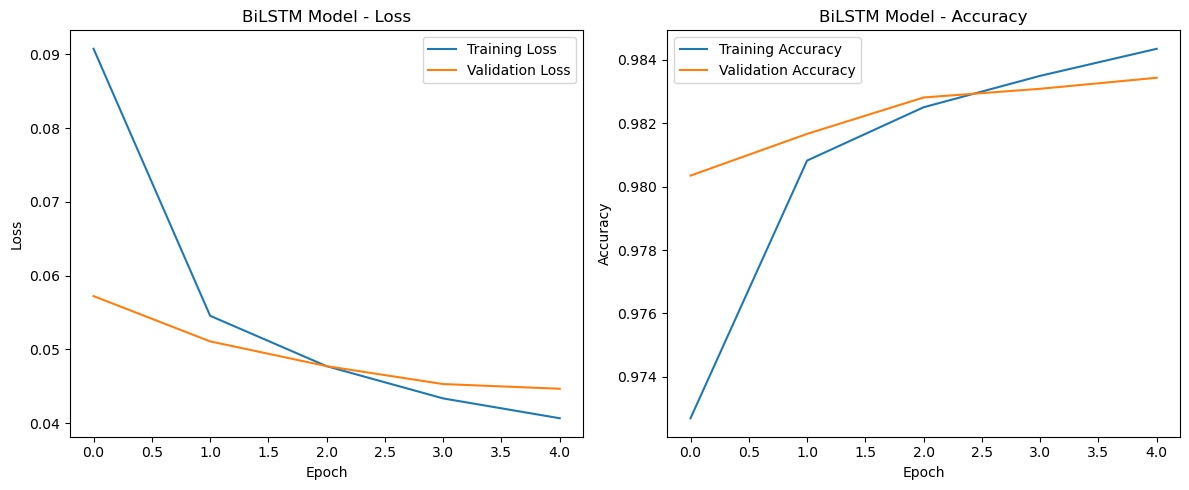

In [29]:
# Add this code before plotting and saving your training history
import os
os.makedirs('../results', exist_ok=True)
plot_training_history(
    lstm_train_losses, lstm_train_accs, lstm_val_losses, lstm_val_accs, "BiLSTM Model"
)

## 6. Train and Evaluate GRU Model

In [ ]:
# Initialize GRU Model
gru_model = GRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
)

# Move model to device (GPU/CPU)
gru_model = gru_model.to(device)
print(gru_model)

In [ ]:
# Define optimizer and loss function
optimizer = optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)

# Train the model
gru_train_losses, gru_train_accs, gru_val_losses, gru_val_accs = train_model(
    gru_model, train_loader, val_loader, criterion, optimizer, device, N_EPOCHS
)

In [ ]:
# Save the trained GRU model
torch.save(gru_model.state_dict(), '../models/gru_model.pt')

# Get predictions and evaluate
gru_preds, gru_actual = predict(gru_model, test_loader, device)
print("\n============ BiGRU Model Evaluation ============")
gru_results = model_performance_metrics(gru_preds, gru_actual, y.columns)

In [ ]:
# Plot training history
plot_training_history(
    gru_train_losses, gru_train_accs, gru_val_losses, gru_val_accs, "BiGRU Model"
)

## 7. Train and Evaluate Attention-based BiLSTM Model

In [ ]:
# Initialize Attention-based BiLSTM Model
attn_lstm_model = AttentionBiLSTM(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
)

# Move model to device (GPU/CPU)
attn_lstm_model = attn_lstm_model.to(device)
print(attn_lstm_model)

In [ ]:
# Define optimizer and loss function
optimizer = optim.Adam(attn_lstm_model.parameters(), lr=LEARNING_RATE)

# Train the model
attn_train_losses, attn_train_accs, attn_val_losses, attn_val_accs = train_model(
    attn_lstm_model, train_loader, val_loader, criterion, optimizer, device, N_EPOCHS
)

In [ ]:
# Save the trained Attention-based BiLSTM model
torch.save(attn_lstm_model.state_dict(), '../models/attn_bilstm_model.pt')

# Get predictions and evaluate
attn_preds, attn_actual = predict(attn_lstm_model, test_loader, device)
print("\n============ Attention BiLSTM Model Evaluation ============")
attn_results = model_performance_metrics(attn_preds, attn_actual, y.columns)

In [ ]:
# Plot training history
plot_training_history(
    attn_train_losses, attn_train_accs, attn_val_losses, attn_val_accs, "Attention BiLSTM Model"
)

## 8. Compare All RNN Models with Previous Models

In [ ]:
# Try to load previous results
try:
    # Load the previous results dataframe
    results_df = pd.read_pickle("../results/vectorizer_model_results.pkl")
    print("Loaded previous model results.")
except FileNotFoundError:
    print("Previous model results not found. Creating new results dataframe.")
    results_df = pd.DataFrame()

In [ ]:
# Add RNN model results to the dataframe
rnn_results = [
    {**lstm_results, 'model_name': 'BiLSTM'},
    {**gru_results, 'model_name': 'BiGRU'},
    {**attn_results, 'model_name': 'Attention BiLSTM'}
]

# Combine with existing results or create new dataframe
if not results_df.empty:
    rnn_df = pd.DataFrame(rnn_results)
    combined_df = pd.concat([results_df, rnn_df], ignore_index=True)
else:
    combined_df = pd.DataFrame(rnn_results)

# Save the combined results
combined_df.to_pickle("../results/all_model_results.pkl")
print("Combined model results saved.")

In [ ]:
# Display all results, sorted by macro F1 score
print("\n\n================ COMBINED RESULTS FOR ALL MODELS ================")
print(combined_df[['model_name', 'accuracy', 'macro_f1', 'micro_f1']].sort_values('macro_f1', ascending=False))

In [ ]:
# Visualize results
plt.figure(figsize=(16, 8))
sns.barplot(x='model_name', y='macro_f1', data=combined_df.sort_values('macro_f1', ascending=False))
plt.title('Models by Macro F1 Score')
plt.xlabel('Model')
plt.ylabel('Macro F1 Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("../results/all_models_comparison.png")
plt.show()

In [ ]:
# Create a heatmap to compare F1 scores across toxicity categories
category_cols = [col for col in combined_df.columns if col.startswith('f1_')]
heatmap_df = combined_df[['model_name'] + category_cols].copy()
heatmap_df.columns = ['model_name'] + [col.split('_', 1)[1] for col in category_cols]
heatmap_df = heatmap_df.set_index('model_name')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5)
plt.title('F1 Scores by Toxicity Category and Model')
plt.tight_layout()
plt.savefig("../results/toxicity_category_heatmap.png")
plt.show()

## 9. Model Deployment for Inference

In [ ]:
class ToxicCommentPredictor:
    def __init__(self, model_path, vocab, device='cpu'):
        self.device = torch.device(device)
        self.vocab = vocab
        
        # Determine model type and load
        if 'bilstm' in model_path.lower():
            self.model = LSTMClassifier(
                vocab_size=len(vocab),
                embedding_dim=EMBEDDING_DIM,
                hidden_dim=HIDDEN_DIM,
                output_dim=OUTPUT_DIM,
                n_layers=N_LAYERS,
                bidirectional=BIDIRECTIONAL,
                dropout=0.0,  # No dropout during inference
                pad_idx=PAD_IDX
            )
        elif 'gru' in model_path.lower():
            self.model = GRUClassifier(
                vocab_size=len(vocab),
                embedding_dim=EMBEDDING_DIM,
                hidden_dim=HIDDEN_DIM,
                output_dim=OUTPUT_DIM,
                n_layers=N_LAYERS,
                bidirectional=BIDIRECTIONAL,
                dropout=0.0,  # No dropout during inference
                pad_idx=PAD_IDX
            )
        elif 'attn' in model_path.lower():
            self.model = AttentionBiLSTM(
                vocab_size=len(vocab),
                embedding_dim=EMBEDDING_DIM,
                hidden_dim=HIDDEN_DIM,
                output_dim=OUTPUT_DIM,
                n_layers=N_LAYERS,
                dropout=0.0,  # No dropout during inference
                pad_idx=PAD_IDX
            )
        else:
            raise ValueError("Unknown model type")
            
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        self.label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        
    def predict(self, text):
        # Tokenize and numericalize
        numericalized_text = self.vocab.numericalize(text)
        tensor = torch.LongTensor(numericalized_text).unsqueeze(0).to(self.device)
        
        # Get predictions
        with torch.no_grad():
            prediction = self.model(tensor).squeeze(0).cpu().numpy()
        
        # Create a dictionary with class probabilities
        result = {}
        for i, label in enumerate(self.label_names):
            result[label] = float(prediction[i])
            
        # Also add binary classifications
        binary_preds = {}
        for label in self.label_names:
            binary_preds[label] = 1 if result[label] > 0.5 else 0
            
        return {
            'probabilities': result,
            'predictions': binary_preds,
            'is_toxic': any(binary_preds.values())
        }

In [ ]:
# Save the vocabulary
with open('../models/rnn_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Create a predictor instance
predictor = ToxicCommentPredictor('../models/best_rnn_model.pt', vocab, device=device)

In [ ]:
# Test the predictor with some example comments
example_texts = [
    "This is a positive comment. I really appreciate your help.",
    "You are an idiot and should not be allowed to post here.",
    "This is neutral content that has no emotional charge.",
    "I strongly disagree with your opinion, but respect your right to have it."
]

for text in example_texts:
    print(f"\nInput: {text}")
    result = predictor.predict(text)
    print(f"Is toxic: {result['is_toxic']}")
    print("Toxicity probabilities:")
    for label, prob in result['probabilities'].items():
        print(f"  {label}: {prob:.4f}")

## 10. Save All Model Architecture Info and Results

In [ ]:
# Create a dictionary with model architectures and hyperparameters
model_info = {
    'BiLSTM': {
        'type': 'LSTM',
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'n_layers': N_LAYERS,
        'bidirectional': BIDIRECTIONAL,
        'dropout': DROPOUT,
        'vocab_size': vocab_size,
        'learning_rate': LEARNING_RATE,
        'epochs': N_EPOCHS
    },
    'BiGRU': {
        'type': 'GRU',
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'n_layers': N_LAYERS,
        'bidirectional': BIDIRECTIONAL,
        'dropout': DROPOUT,
        'vocab_size': vocab_size,
        'learning_rate': LEARNING_RATE,
        'epochs': N_EPOCHS
    },
    'Attention BiLSTM': {
        'type': 'Attention BiLSTM',
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'n_layers': N_LAYERS,
        'bidirectional': True,  # Always bidirectional for this model
        'dropout': DROPOUT,
        'vocab_size': vocab_size,
        'learning_rate': LEARNING_RATE,
        'epochs': N_EPOCHS
    }
}

# Save the model information
with open('../models/rnn_model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

In [ ]:
# Create a summary dictionary for easy comparison
summary = {
    'model_comparison': combined_df[['model_name', 'accuracy', 'macro_f1', 'micro_f1']].sort_values('macro_f1', ascending=False).to_dict('records'),
    'best_model': combined_df.loc[combined_df['macro_f1'].idxmax()]['model_name'],
    'model_info': model_info
}

# Save the summary
with open('../results/rnn_models_summary.pkl', 'wb') as f:
    pickle.dump(summary, f)

print(f"Best model: {summary['best_model']}")

## 11. Conclusion

In this notebook, we have:

1. Implemented three RNN architectures for toxic comment classification:
   - Bidirectional LSTM
   - Bidirectional GRU
   - Attention-based Bidirectional LSTM

2. Trained and evaluated each model on the toxic comment dataset

3. Compared the RNN models with previously trained traditional ML models

4. Created a simple inference system for making predictions on new text

5. Saved the models, their architectures, and evaluation results for future use

The RNN models, especially those with attention mechanisms, can capture sequential information in the text that traditional bag-of-words models like TF-IDF might miss, potentially improving the detection of complex toxic patterns.